# 1. Comparaison distance longueur

In [1]:
%run ../code_python/comparaison_distance_longueur_moyenne.py

## 1.1. Dans une grille

### 1.1.1. Grille 2 $\times$ n

Pour une grille de taille $2 \times n$ le calcul théorique donne :
- distance moyenne entre deux noeuds du graphe : $d_{moy} \sim \frac{n}{3}$
- longueur moyenne d'un plus court chemin du graphe : $l_{moy} \sim \frac{n}{2}$
- rapport des deux grandeurs : $\frac{l_{moy}}{d_{moy}} \sim \frac{3}{2}$

In [10]:
echant_2xN = echantillon_grille(dimensions = [(2,floor(n)) for n in np.linspace(1,100, 50)])

In [14]:
data_2xN = calcul_longueur_et_distance_moyenne(echant_2xN)

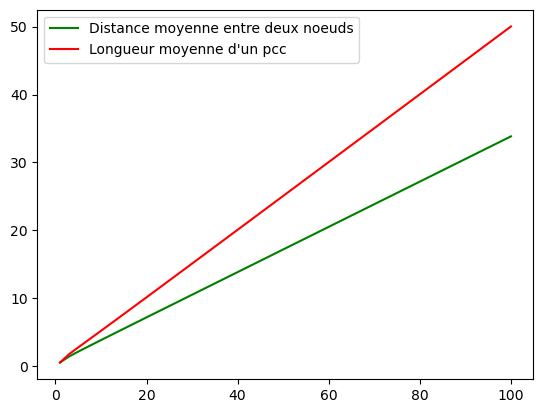

In [17]:
compare_dist_long(data_2xN, abcisse = [floor(n) for n in np.linspace(1,100, 50)])

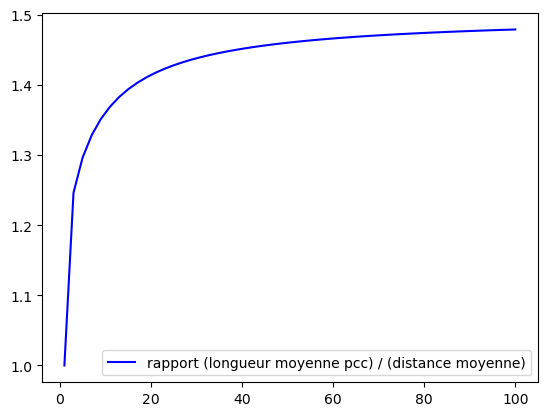

In [18]:
rapport_long_sur_dist(data_2xN, abcisse = [floor(n) for n in np.linspace(1,100, 50)])

### 1.1.2. Grille m $\times$ n

Pour une grille de taille $m \times n$ où $m$ est une constante fixée et $n \to +\infty$, le calcul théorique donne :
- distance moyenne entre deux noeuds du graphe : $d_{moy} \sim \frac{n}{3}$
- longueur moyenne d'un plus court chemin du graphe : $l_{moy} \sim \frac{mn}{m+2}$
- rapport des deux grandeurs : $\frac{l_{moy}}{d_{moy}} \sim \frac{3m}{m+2}$

In [2]:
m = 6
rapport = 3*m/(m+2)
rapport

2.25

In [22]:
echant_MxN = echantillon_grille(dimensions = [(m,n) for n in range(1,50)])

In [23]:
data_MxN = calcul_longueur_et_distance_moyenne(echant_MxN)

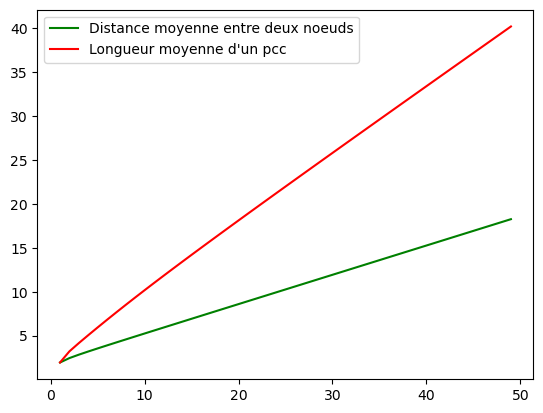

In [24]:
compare_dist_long(data_MxN, abcisse = [n for n in range(1,50)])

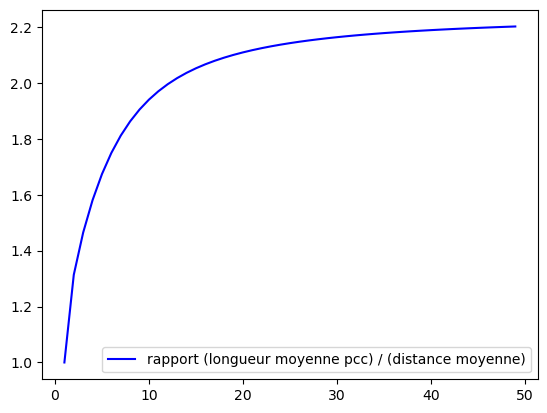

In [27]:
rapport_long_sur_dist(data_MxN, abcisse = [n for n in range(1,50)])

### 1.1.3. Grille n^k = $n \times \dots \times n$

In [5]:
echant_N2 = echantillon_grille(dimensions = [(n,n) for n in range(2,21)])

In [6]:
data_N2 = calcul_longueur_et_distance_moyenne(echant_N2)

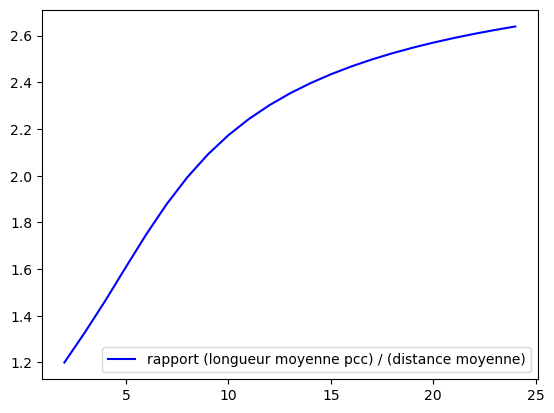

In [8]:
rapport_long_sur_dist(data_N2, abcisse = [n for n in range(2,21)])

In [42]:
echant_N3 = echantillon_grille(dimensions = [(n,n,n) for n in range(2,11)])

In [43]:
data_N3 = calcul_longueur_et_distance_moyenne(echant_N3)

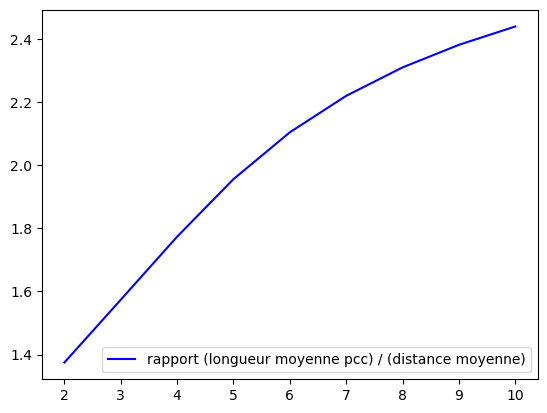

In [44]:
rapport_long_sur_dist(data_N3, abcisse = [n for n in range(2,11)])

## 1.2. Graphe aléatoire

In [9]:
m = 3
echant_BA = echantillon_barabasi_albert(m = m)
echant_ER = echantillon_erdos_renyi()

In [10]:
data_BA = calcul_longueur_et_distance_moyenne(echant_BA)
data_ER = calcul_longueur_et_distance_moyenne(echant_ER)

La longueur moyenne théorique d'un plus court chemin est : 
- $l_{BA} = \frac{\log(N) - \log(m/2) - 1 -  \gamma}{\log( \log(N)) + \log(m/2)} + \frac{3}{2}$ pour les Barabasi Albert
- $l_{ER} = \frac{\log(N) - \gamma}{\log(\langle deg \rangle)} + \frac{1}{2}$ pour les Erdos Renyi

In [11]:
gamma = 0.5772156649
valeur_theo_BA = [(log(len(G)) - log(m/2) - 1 - gamma)/(log(log(len(G))) + log(m/2)) + 1.5 for G in echant_BA]
valeur_theo_ER = [(log(len(G)) - gamma)/(log(degre_moyen(G))) + 0.5 for G in echant_ER]

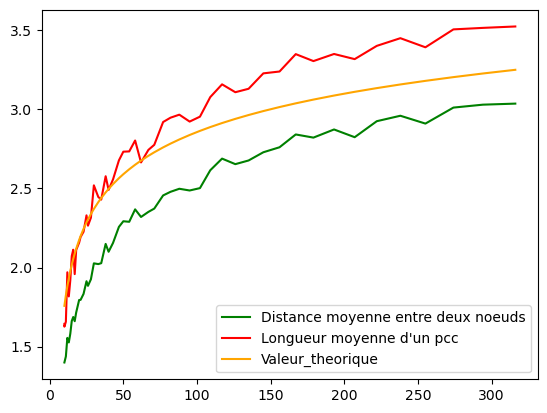

In [12]:
compare_dist_long(data_BA, valeur_theorique = valeur_theo_BA)

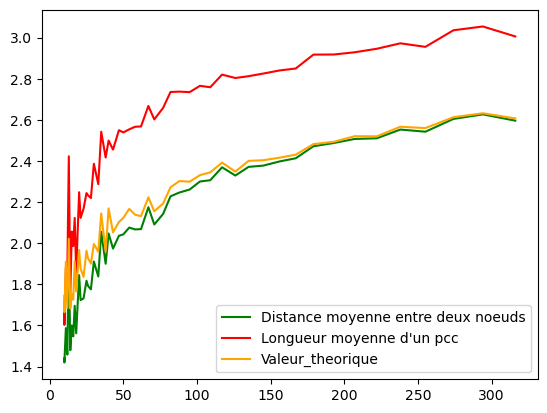

In [13]:
compare_dist_long(data_ER, valeur_theorique = valeur_theo_ER)

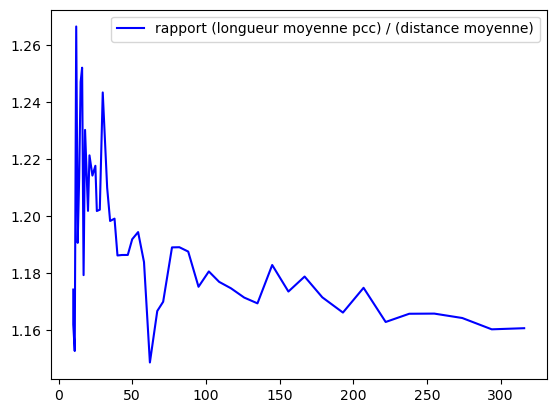

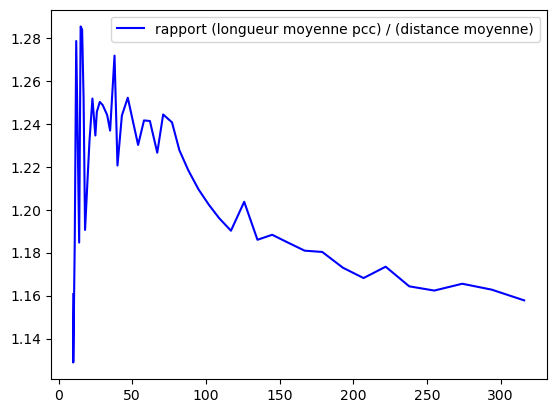

(None, None)

In [14]:
rapport_long_sur_dist(data_BA),rapport_long_sur_dist(data_ER)

### Erdos Renyi en fonction de p

In [22]:
# Echantillon de nb_points graphes de n noeuds avec proba variant entre p_min et p_max
echant_ER_p, proba = echantillon_erdos_renyi_p(0.01,1, nb_points = 50, n = 100)

In [23]:
data_ER_p = calcul_longueur_et_distance_moyenne(echant_ER_p)

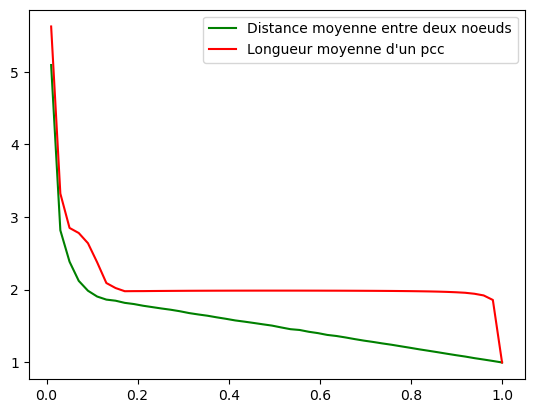

In [24]:
compare_dist_long(data_ER_p, abcisse = proba)

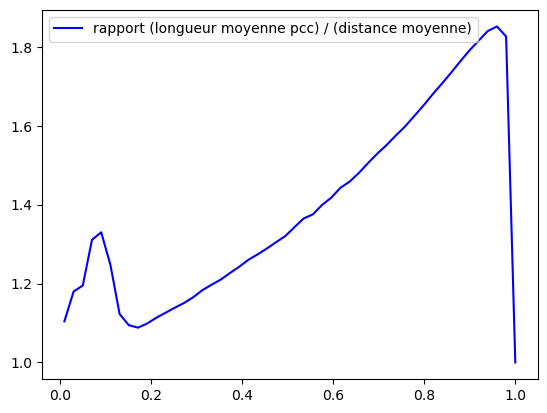

In [25]:
rapport_long_sur_dist(data_ER_p, abcisse = proba)

Que ce soit sur les graphes aléatoires ou les grilles, le rapport $\frac{l_{moy}}{d_{moy}}$ semble toujours borné... 

Famille de graphes telle que $d_{moy} \sim C \sqrt{n}$ ? 

### Nombre de PCC en fonction de p

In [19]:
data_pcc_ER = nombre_PCC(echant_ER_p)

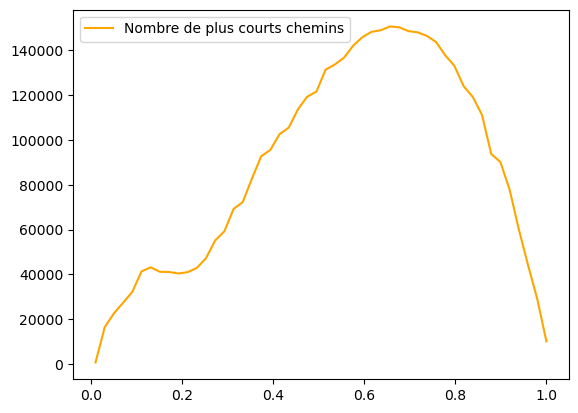

In [20]:
graphe_nb_PCC(data_pcc_ER,abcisse = proba)

# 2. Algorithme pour les graphes à poids

In [21]:
%run ../code_python/Algo_poids_v1.py

## 2.1. Algorithme

In [14]:
## Fonctions

def Dijkstra_dist(G,source):
    """Renvoie le dictionnaire des distances au point source"""
    dist = nx.single_source_dijkstra_path_length(G,source, weight = "length")
    return dist




def Selected_edges(G,dist,poids,epsilon):
    """ Renvoie la liste des arêtes qui peuvent être empruntées dans des ePCC. """
    selected = []
    for e in G.edges(keys = True):
        u,v = e[0],e[1]
        if (u in dist and v in dist and poids[e] <= (1 + epsilon)*(dist[v] - dist[u])):
            selected.append(e)
    return selected



def Table_ePCC_In_Place(G,dist,poids,tables,source, epsilon):
    """ Remplit une table avec en coord (source,arrivee) le nb d'epsilon PCC de source à arrivee. """
    nodes_by_increasing_dist = sorted(dist.keys(), key=lambda x:dist[x])

    tables[source][source] = 1

    for u in nodes_by_increasing_dist[1:]:
        for e in G.in_edges(u,keys = True):                                      # key = True pour traiter le cas où on a des multi-edges
            if (e[0] in dist and poids[e] <= (1 + epsilon)*(dist[e[1]] - dist[e[0]])):
                tables[source][u] += tables[source][e[0]]



def Construct_DAG(G,selected_edges,tables,source):
    """ Construit le DAG enraciné en source qui donne les ePredecesseur avec la somme partielle des ePCC en deuxième coordonnée. """
    pred = {}
    pred[source] = []
    for e in selected_edges:
        u, v = e[0], e[1]
        if v in pred:
            pred[v].append((u,tables[source][u] + pred[v][-1][1]))
        else :
            pred[v] = [(u,tables[source][u])]
    return pred

In [15]:
def Preprocessing_Graph_poids_v1(G,epsilon = 0.5):
    """ Renvoie un tuple (dags,table_departs,nb_chemins) avec
        - dags[i] = liste des dictionnaires de predecesseurs avec source i avec la somme partielle en 2eme coordonnée
        dags[depart][i][1] = dags[depart][i-1][1] + nb de ePCC (depart)-->(dags[depart][i])
        - table_departs_arrivees[depart][j] = table_departs_arrivees[depart][j-1] + nb de ePCC (depart)-->(j)
        - table_departs[i] = table_departs[i-1] + nombre d'epsilon pcc (i)-->(?) """

    n = len(G)
    tables = np.zeros((n,n))
    dags = []

    poids = nx.get_edge_attributes(G,"length")

    
    
    for source in range(n):
        dist = Dijkstra_dist(G,source)
        Table_ePCC_In_Place(G,dist,poids,tables,source,epsilon)
        selected_edges = Selected_edges(G,dist,poids,epsilon)
        dag_pred = Construct_DAG(G,selected_edges,tables,source)
        dags.append(dag_pred)


        
    # Tables et variables pour déterminer les départs et arrivées
    table_departs_arrivees = np.copy(tables)
    for depart in range(n):
        for k in range(n-1):
            table_departs_arrivees[depart][k+1] += table_departs_arrivees[depart][k]

    table_departs = np.sum(tables,axis = 1)
    for k in range(n-1):
        table_departs[k+1] += table_departs[k]

    nb_chemins = int(table_departs[-1])

    return (dags,table_departs_arrivees,table_departs,nb_chemins)

Le même générateur que pour l'algo sans les poids. (Ici celui où on fait des dichotomies à toutes les étapes)

In [16]:
Palaiseau = loadVille("palaiseau")

In [17]:
len(Palaiseau)

683

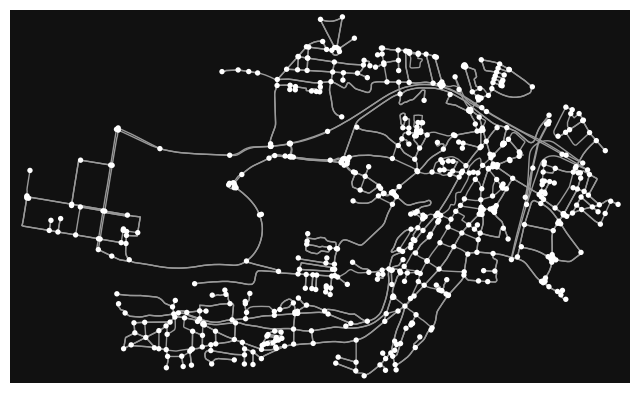

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [73]:
ox.plot_graph(Palaiseau)

In [18]:
palaiseau = Preprocessing_Graph_poids_v1(Palaiseau, epsilon = 0.5)

<Figure size 640x480 with 0 Axes>

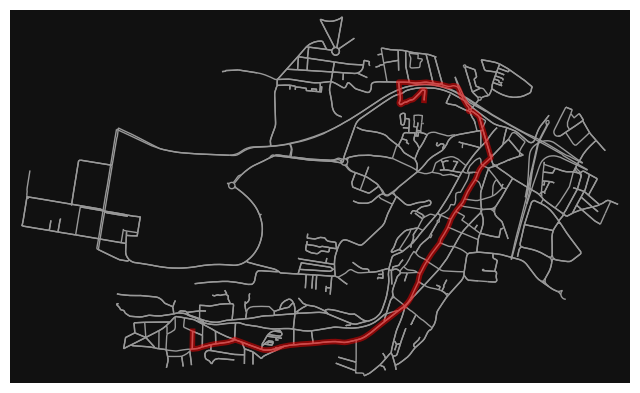

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [21]:
DrawOX_Uniforme_ePCC_v1(Palaiseau,palaiseau)

## 2.2. Combien d'ePCC?

In [22]:
ePCC = []
for epsilon in [0.0001,0.1, 0.3, 0.5, 1, 2]:
    pal = Preprocessing_Graph_poids_v1(Palaiseau, epsilon = epsilon)
    ePCC.append(pal[-1])
    
ePCC

[444292, 647305, 976582, 1296688, 2449444, 3961008]

In [83]:
len(Palaiseau)**2

466489

In [97]:
comp = nx.strongly_connected_components(Palaiseau)
[len(c) for c in comp]

[1, 1, 1, 1, 4, 1, 1, 1, 657, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1]

## 2.3. Complexité

In [101]:
%run ../code_python/Complexite_operations.py

In [106]:
echant_BA = echantillon_barabasi_albert()
echant_ER = echantillon_erdos_renyi()

In [107]:
#data_BA_classique = calcul_donnees(c_Preprocessing_Graph_v3, c_Uniforme_PCC_v3, echant_BA)
data_ER_classique = calcul_donnees(c_Preprocessing_Graph_v3, c_Uniforme_PCC_v3, echant_ER)
#data_BA_poids = calcul_donnees(c_Preprocessing_Graph_poids_v1, c_Uniforme_ePCC_v1, echant_BA)
data_ER_poids = calcul_donnees(c_Preprocessing_Graph_poids_v1, c_Uniforme_ePCC_v1, echant_ER)

In [108]:
#data = [data_BA_classique, data_ER_classique, data_BA_poids, data_ER_poids]
data = [data_ER_classique, data_ER_poids]

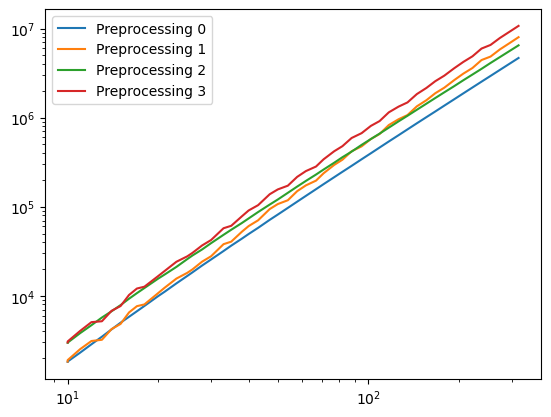

In [111]:
complexite_comparaison_donnees(data, generateur = False)

# 3. Dénombrement des DAG

Voir présentations Sage:
- $dd_n \sim C 2^{\frac{n^2}{4}}$ $\Longrightarrow$ voir serie_gen_ddn
- $d_n = 2^{\binom{n+1}{2}} e^{-an} f(n)$ $\Longrightarrow$ voir serie_gen
- Série génératrice à poids et rayon de convergence non nul. $\Longrightarrow$ voir serie_gen_poids